In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import SPCI_class as SPCI
from sklearn.model_selection import train_test_split

In [14]:

market_data = yf.download (tickers = "^GSPC", start = "2010-04-01", end = "2024-03-31", interval = "1d") # start="1927-12-30"
market_data["pct_change"] = market_data["Close"].pct_change()
market_data['date_ordinal'] = pd.to_datetime(market_data.index.to_series()).apply(lambda date: date.toordinal())
market_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal
Date,,,,,,,,
2010-04-01,1171.229980,1181.430054,1170.689941,1178.099976,1178.099976,4006870000,NaN,733863
2010-04-05,1178.709961,1187.729980,1178.709961,1187.439941,1187.439941,3881620000,0.007928,733867
2010-04-06,1186.010010,1191.800049,1182.770020,1189.439941,1189.439941,4086180000,0.001684,733868
2010-04-07,1188.229980,1189.599976,1177.250000,1182.449951,1182.449951,5101430000,-0.005877,733869
2010-04-08,1181.750000,1188.550049,1175.119995,1186.439941,1186.439941,4726970000,0.003374,733870


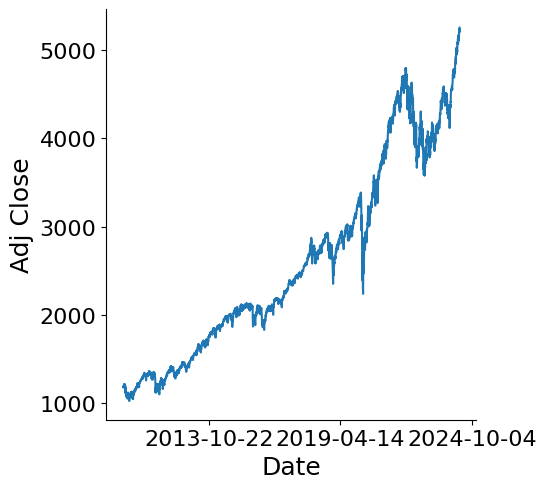

In [15]:
sns.relplot(market_data, x="Date", y="Adj Close", kind="line")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(3))

### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.

In [16]:
# Plot prediction intervals on test sample
def plot_ci(model, x_train, y_train, x_test, y_test, past_window = 30, alpha=0.1):

    SPCI_class_  = SPCI.SPCI_and_EnbPI(
        torch.from_numpy(x_train), 
        torch.from_numpy(x_test), 
        torch.from_numpy(y_train.reshape(-1)), 
        torch.from_numpy(y_test.reshape(-1)), 
        fit_func=model)
    stride = 1
    SPCI_class_.fit_bootstrap_models_online_multistep(B = 25, fit_sigmaX=False, stride=stride)

    use_SPCI = True
    smallT = not use_SPCI
    SPCI_class_.compute_PIs_Ensemble_online(alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI, quantile_regr=True, stride=stride)
    results = SPCI_class_.get_results(alpha, 'my_data', 1)

    Pred_ints = SPCI_class_.PIs_Ensemble
#     Y_est = SPCI_class_.Ensemble_pred_interval_centers
#     Y_predict = SPCI_class_.Y_predict.numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label=r'$Y$')
    plt.plot(model.predict(x_test), label=r'$\hat{Y}$')
    plt.fill_between(np.arange(len(y_test)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$', color='lightblue')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
    # plt.xlabel('Test time index')
    plt.ylabel('True $Y$ and prediction')
    # actual_cov = 100*results["coverage"].item()
    # actual_wid = results["width"].item()
    # plt.title(f'Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')

In [42]:
market_data.head()

,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
Date,,,,,,,,,,,,,,,
2011-09-12,1153.500000,1162.520020,1136.069946,1162.270020,1162.270020,5168550000,0.006966,734392,1175.591992,1175.591992,1214.772519,0.967747,17.339802,1214.772519,0.014274
2011-09-13,1162.589966,1176.410034,1157.439941,1172.869995,1172.869995,4681370000,0.009120,734393,1173.252002,1173.252002,1214.729149,0.965855,18.372133,1214.729149,0.015124
2011-09-14,1173.319946,1202.380005,1162.729980,1188.680054,1188.680054,4986740000,0.013480,734394,1174.778003,1174.778003,1214.689231,0.967143,17.849729,1214.689231,0.014695
2011-09-15,1189.439941,1209.109985,1189.439941,1209.109985,1209.109985,4479730000,0.017187,734395,1172.790015,1172.790015,1214.687149,0.965508,14.828328,1214.687149,0.012208
2011-09-16,1209.209961,1220.060059,1204.459961,1216.010010,1216.010010,5248890000,0.005707,734396,1177.432007,1177.432007,1214.760191,0.969271,21.903451,1214.760191,0.018031


In [43]:
market_data['5_day_avg'] = market_data['Adj Close'].rolling(window=5).mean().shift(1)
market_data['30_day_avg']= market_data['Adj Close'].rolling(window=5).mean().shift(1)
market_data['year_avg'] = market_data['Adj Close'].rolling(window=365).mean().shift(1)
market_data['avg_ratio'] = market_data['5_day_avg']/market_data['year_avg']

market_data['5_day_std'] = market_data['Adj Close'].rolling(window=5).std().shift(1)
market_data['year_std'] = market_data['Adj Close'].rolling(window=365).mean().shift(1)
market_data['std_ratio'] = market_data['5_day_std']/market_data['year_std']
market_data.head()

,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
Date,,,,,,,,,,,,,,,
2011-09-12,1153.500000,1162.520020,1136.069946,1162.270020,1162.270020,5168550000,0.006966,734392,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-13,1162.589966,1176.410034,1157.439941,1172.869995,1172.869995,4681370000,0.009120,734393,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-14,1173.319946,1202.380005,1162.729980,1188.680054,1188.680054,4986740000,0.013480,734394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-15,1189.439941,1209.109985,1189.439941,1209.109985,1209.109985,4479730000,0.017187,734395,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-16,1209.209961,1220.060059,1204.459961,1216.010010,1216.010010,5248890000,0.005707,734396,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
market_data = market_data.dropna()
print(market_data.shape)
x_train, x_test, y_train, y_test = train_test_split(market_data[['5_day_avg', '30_day_avg', 'year_avg', 'avg_ratio', '5_day_std','year_std', 'std_ratio']], market_data["Adj Close"], test_size=30/market_data.shape[0], shuffle=False)
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(2792, 15)


((2762, 7), (30, 7), (2762, 1), (30, 1))

In [45]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.0635979175567627 secs.
Shape of slided residual lists is (30, 2762)
Width at test 0 is 92.95741271972656
Width at test 1 is 112.29787826538086
Width at test 2 is 94.157470703125
Width at test 3 is 120.19331741333008
Width at test 4 is 103.56625747680664
Width at test 5 is 154.93689250946045
Width at test 6 is 132.12644386291504
Width at test 7 is 130.40592765808105
Width at test 8 is 122.86615371704102
Width at test 9 is 94.82024765014648
Width at test 10 is 92.00219345092773
Width at test 11 is 112.91119003295898
Width at test 12 is 115.37180709838867
Width at test 13 is 124.60916137695312
Width at test 14 is 96.06187057495117
Width at test 15 is 118.84354400634766
Width at test 16 is 97.63612747192383
Width at test 17 is 98.60134887695312
Width at test 18 is 120.24710845947266
Width at test 19 is 112.38425064086914
Width at test 20 is 93.53169250488281
Width at test 21 is 130.22414016723633
Width at test 22 is 91.666965484619

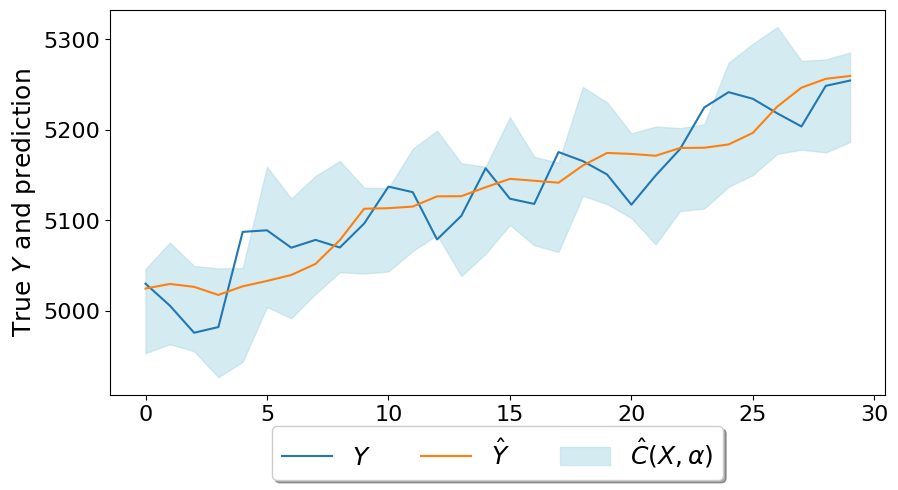

In [46]:
plot_ci(model, x_train, y_train, x_test, y_test, past_window=365, alpha=0.1)

Text(0, 0.5, 'True $Y$ and prediction')

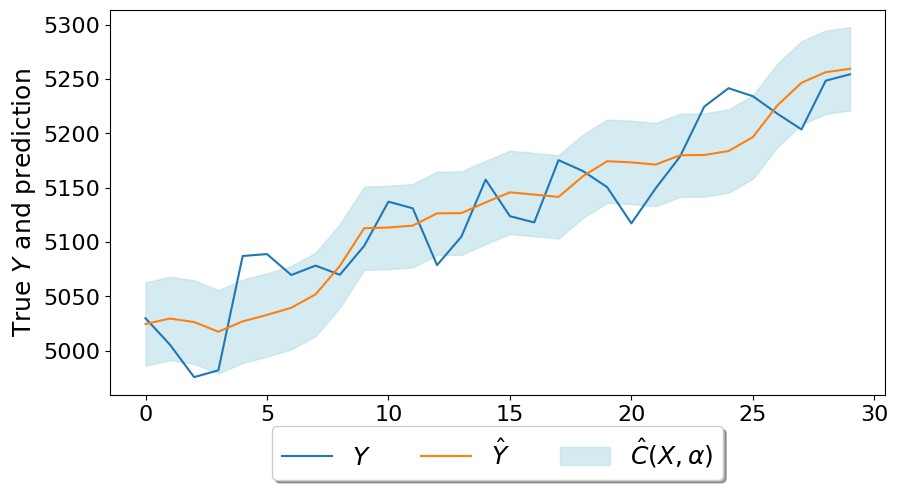

In [53]:
from scipy.stats import t

predictions = model.predict(x_test).reshape(-1)
test_length = 30

alpha = 0.1

residuals = y_test - predictions
mse = np.mean(residuals**2)
se = np.sqrt(mse / (test_length - 8))

t_statistic = t.ppf(1 - alpha / 2, test_length - 8)

lower_bound = predictions - t_statistic * se
upper_bound = predictions + t_statistic * se

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test, label=r'$Y$')
plt.plot(predictions, label=r'$\hat{Y}$')
# plt.plot(predictions, color='blue', label='Predictions')
# plt.plot(y_test, color='black', label='Actuals')
plt.fill_between(np.arange(len(y_test)), lower_bound, upper_bound, alpha=0.5, label=r'$\hat{C}(X,\alpha)$', color='lightblue')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
# plt.xlabel('Dates')
plt.ylabel('True $Y$ and prediction')
# plt.title('Linear Regression Predictions with 90% Confidence Interval')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
import pandas as pd
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

auto_arima(market_data["Adj Close"], seasonal=True, trace=True)

In [ ]:
class Arima:
    def __init__(self):
        self.model = None
    
    def fit(self, x, y):
        self.model = ARIMA(order=(5,2,10)).fit(y)

    def predict(self, x):
        return self.model.predict(n_periods=len(x))

In [ ]:
model = Arima()
model.fit(x_train, y_train)


In [ ]:
model.predict(x_test)

In [ ]:
plot_ci(model, x_train, y_train, x_test, y_test, past_window=365, alpha=0.1)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label=r'$Y$')
plt.plot(model.predict(x_test), label=r'$\hat{Y}$')
# plt.fill_between(np.arange(len(y_test)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$', color='lightblue')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
# plt.xlabel('Test time index')
plt.ylabel('True $Y$ and prediction')
    

In [22]:
import tensorflow as tf

nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(50, input_shape=(x_train.shape[1],), activation=tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(50, activation=tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))

nn_model.compile(optimizer="adam", loss="mean_squared_error")

validation_samples = int(0.2 * x_train.shape[0])

nn_model.fit(x_train[:-validation_samples], y_train[:-validation_samples], 
          validation_data=(x_train[-validation_samples:], y_train[-validation_samples:]), 
          epochs=100)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 915040.5000 - val_loss: 39069.1328
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4625.0840 - val_loss: 21446.3691
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2993.4197 - val_loss: 17308.5977
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2903.2578 - val_loss: 11673.7832
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2097.3433 - val_loss: 8856.4766
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1804.5260 - val_loss: 7595.0146
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1488.4685 - val_loss: 5532.9248
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1301.6615 - val_loss: 4901.5737
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1243.9136 - val_loss: 5317.1592
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1265.6807 - val_loss: 4894.3467
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1214.9115 - val_loss: 4

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 2082.0774
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 2409.1802
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 2586.2622
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2560.8958
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 1960.9495
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 2514.8044
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 2235.4543
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 2610.8069
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 2025.8168
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 2570.1035
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
98/98 

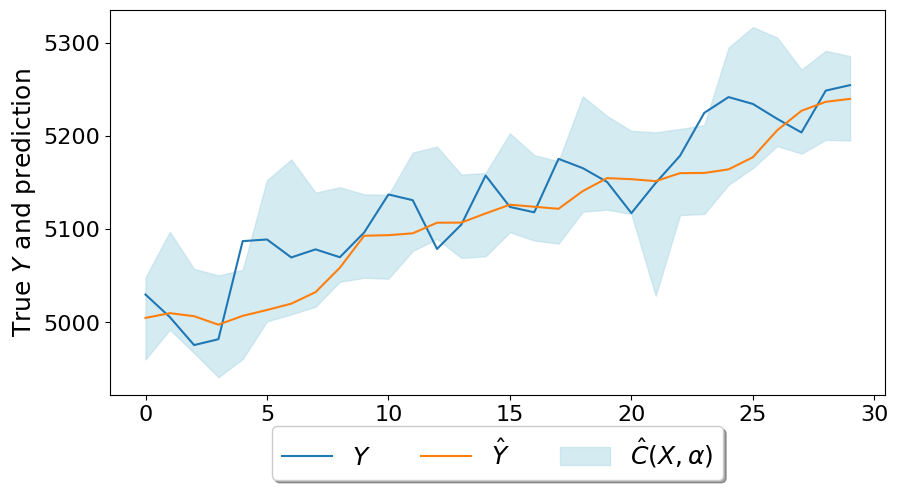

In [23]:
plot_ci(nn_model, x_train, y_train, x_test, y_test, past_window=365, alpha=0.1)